In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from scipy.stats import norm

import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

np.random.seed(42)

print("Bibliothèques importées. Début de l'exemple enrichi.")


Bibliothèques importées. Début de l'exemple enrichi.


In [47]:
# =========================
# 1) Paramètres fixes & BS
# =========================
r     = 0.01  # Taux risk-free
sigma = 0.2   # Volatilité
K     = 100.0 # Strike
T     = 1.0   # Maturité (en années)

def bs_call_price(S):
    """Prix BS call (Européen) en 1D avec param. fixes."""
    if T <= 1e-12:
        return max(S - K, 0.0)
    d1 = (np.log(S / K) + (r + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_put_price(S):
    """Prix BS put (Européen) en 1D avec param. fixes."""
    if T <= 1e-12:
        return max(K - S, 0.0)
    d1 = (np.log(S / K) + (r + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    # put-call parity => put = call + K e^{-rT} - S
    call_val = bs_call_price(S)
    put_val = call_val + K*np.exp(-r*T) - S
    return put_val

print(f"Exemple: Call( S=100 ) = {bs_call_price(100):.4f}")
print(f"         Put(  S=100 ) = {bs_put_price(100):.4f}")


Exemple: Call( S=100 ) = 8.4333
         Put(  S=100 ) = 7.4383


In [48]:
# ==================================
# 2) Génération de différents maillages
# ==================================
# On va comparer 3 stratégies pour "X_train" (S):
#   1) Grille uniforme
#   2) Grille random
#   3) Grille dense autour du strike (K=100)

def gen_grid_uniform(n_points=3, s_min=50, s_max=150):
    S_vals = np.linspace(s_min, s_max, n_points)
    return S_vals

def gen_grid_random(n_points=3, s_min=50, s_max=150):
    S_vals = np.random.uniform(s_min, s_max, n_points)
    S_vals.sort()  # juste pour visualiser
    return S_vals

def gen_grid_dense_near_strike(n_points=3, s_min=50, s_max=150, center=100):
    """
    Ex: on place 40% des points dans [K-10, K+10],
        et le reste dans [s_min, K-10] U [K+10, s_max].
    """
    n_dense = int(0.4 * n_points)
    n_sparse = n_points - n_dense
    
    # dense
    dense_min, dense_max = center-10, center+10
    S_dense = np.linspace(dense_min, dense_max, n_dense)
    
    # sparse
    left_part  = np.linspace(s_min, dense_min, n_sparse//2)
    right_part = np.linspace(dense_max, s_max, n_sparse - n_sparse//2)
    
    S_vals = np.concatenate([left_part, S_dense, right_part])
    S_vals.sort()
    return S_vals

def create_training_dataset(S_array, which="call"):
    """Retourne X_train(2D), y_train(1D) en fonction de S_array."""
    X_train = S_array.reshape(-1,1)
    if which == "call":
        y_train = np.array([bs_call_price(s) for s in S_array])
    elif which == "put":
        y_train = np.array([bs_put_price(s) for s in S_array])
    else:
        raise ValueError("unknown which=??? (call|put)")
    return X_train, y_train

S_test = np.linspace(50,150,300)
X_test = S_test.reshape(-1,1)

y_test_call = np.array([bs_call_price(s) for s in S_test])
y_test_put  = np.array([bs_put_price(s)  for s in S_test])

print("Fonctions de génération de grilles définies.")


Fonctions de génération de grilles définies.


In [ ]:
# ================================================
# 3) Test sur le Call: Comparer uniform/random/dense
# ================================================

def train_and_evaluate_gp(S_train, y_train, X_test, y_test):
    """Entraîne un GP standard et calcule la MSE sur le test."""
    kernel = ConstantKernel(1.0) * RBF(length_scale=10.0)  # param fixés
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-8, random_state=42)
    gp.fit(S_train.reshape(-1,1), y_train)
    
    y_pred = gp.predict(X_test)
    mse = np.mean((y_pred - y_test)**2)
    return gp, mse, y_pred

n_pts = 15

S_unif  = gen_grid_uniform(n_pts)
S_rand  = gen_grid_random(n_pts)
S_dense = gen_grid_dense_near_strike(n_pts)

# Pour le call
Xu, yu = create_training_dataset(S_unif, "call")
Xr, yr = create_training_dataset(S_rand, "call")
Xd, yd = create_training_dataset(S_dense,"call")

gp_u, mse_u, ypred_u = train_and_evaluate_gp(Xu[:,0], yu, X_test, y_test_call)
gp_r, mse_r, ypred_r = train_and_evaluate_gp(Xr[:,0], yr, X_test, y_test_call)
gp_d, mse_d, ypred_d = train_and_evaluate_gp(Xd[:,0], yd, X_test, y_test_call)

print("CALL - Comparaison MSE:")
print(f"Uniform grid MSE = {mse_u:.6f}")
print(f"Random  grid MSE = {mse_r:.6f}")
print(f"Dense   grid MSE = {mse_d:.6f}")


NameError: name 'n_p15ts' is not defined

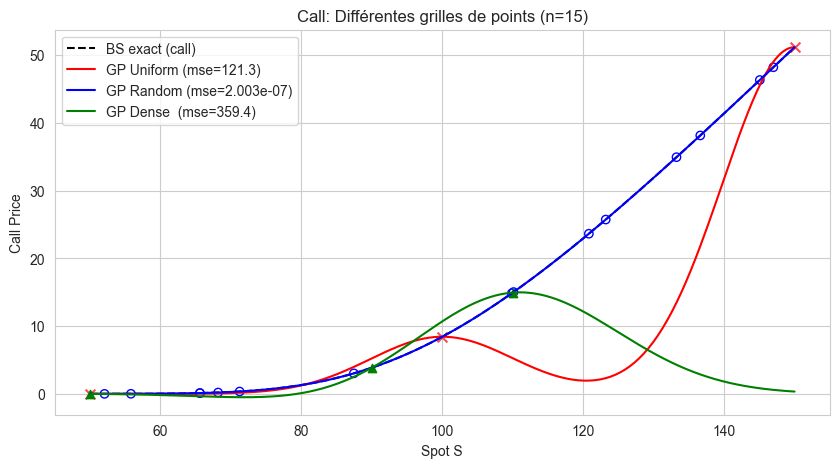

In [ ]:
# Plot comparatif pour le call
plt.figure(figsize=(10,5))

plt.plot(S_test, y_test_call, 'k--', label="BS exact (call)")

# Traces
plt.plot(S_test, ypred_u, 'r-',  label=f"GP Uniform (mse={mse_u:.4g})")
plt.plot(S_test, ypred_r, 'b-',  label=f"GP Random (mse={mse_r:.4g})")
plt.plot(S_test, ypred_d, 'g-',  label=f"GP Dense  (mse={mse_d:.4g})")

# Points
plt.scatter(S_unif, [bs_call_price(s) for s in S_unif], marker='x', c='r', s=50, alpha=0.7)
plt.scatter(S_rand, [bs_call_price(s) for s in S_rand], marker='o', facecolors='none', edgecolors='b')
plt.scatter(S_dense,[bs_call_price(s) for s in S_dense],marker='^', c='g')

plt.title("Call: Différentes grilles de points (n=15)")
plt.xlabel("Spot S")
plt.ylabel("Call Price")
plt.legend()
plt.show()


In [ ]:
# ========================================
# 4) Faire la même chose pour le PUT
# ========================================
S_unif_p  = gen_grid_uniform(n_pts)
S_rand_p  = gen_grid_random(n_pts)
S_dense_p = gen_grid_dense_near_strike(n_pts)

Xu_p, yu_p = create_training_dataset(S_unif_p, "put")
Xr_p, yr_p = create_training_dataset(S_rand_p, "put")
Xd_p, yd_p = create_training_dataset(S_dense_p,"put")

gp_u_p, mse_u_p, ypred_u_p = train_and_evaluate_gp(Xu_p[:,0], yu_p, X_test, y_test_put)
gp_r_p, mse_r_p, ypred_r_p = train_and_evaluate_gp(Xr_p[:,0], yr_p, X_test, y_test_put)
gp_d_p, mse_d_p, ypred_d_p = train_and_evaluate_gp(Xd_p[:,0], yd_p, X_test, y_test_put)

print("PUT - Comparaison MSE:")
print(f"Uniform grid MSE = {mse_u_p:.6f}")
print(f"Random  grid MSE = {mse_r_p:.6f}")
print(f"Dense   grid MSE = {mse_d_p:.6f}")


PUT - Comparaison MSE:
Uniform grid MSE = 97.597456
Random  grid MSE = 9.929187
Dense   grid MSE = 5.588576


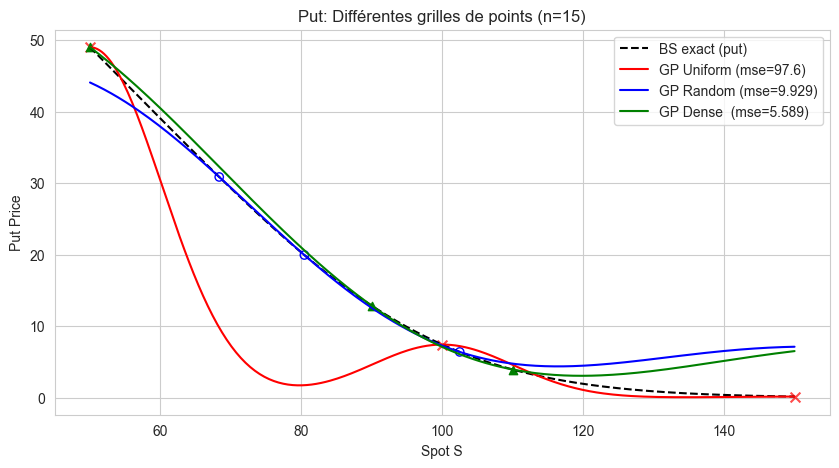

In [ ]:
# Visu du PUT
plt.figure(figsize=(10,5))

plt.plot(S_test, y_test_put, 'k--', label="BS exact (put)")

plt.plot(S_test, ypred_u_p, 'r-', label=f"GP Uniform (mse={mse_u_p:.4g})")
plt.plot(S_test, ypred_r_p, 'b-', label=f"GP Random (mse={mse_r_p:.4g})")
plt.plot(S_test, ypred_d_p, 'g-', label=f"GP Dense  (mse={mse_d_p:.4g})")

# Points
plt.scatter(S_unif_p, [bs_put_price(s) for s in S_unif_p], marker='x', c='r', s=50, alpha=0.7)
plt.scatter(S_rand_p, [bs_put_price(s) for s in S_rand_p], marker='o', facecolors='none', edgecolors='b')
plt.scatter(S_dense_p,[bs_put_price(s) for s in S_dense_p],marker='^', c='g')

plt.title("Put: Différentes grilles de points (n=15)")
plt.xlabel("Spot S")
plt.ylabel("Put Price")
plt.legend()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Straddle MSE (grid uniforme) = 0.000000


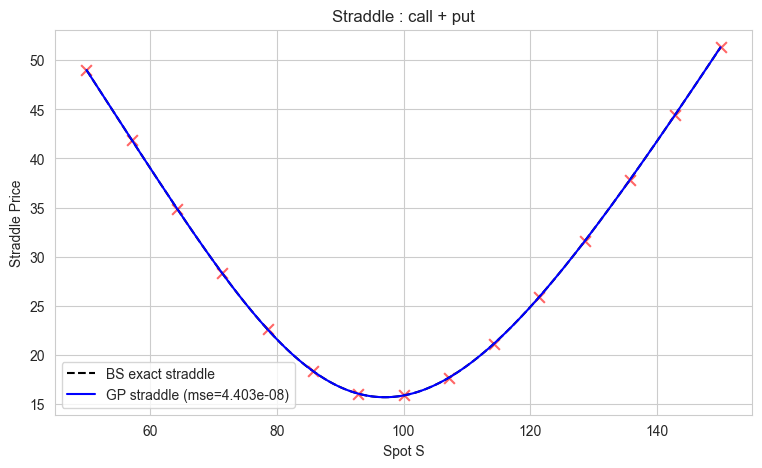

In [ ]:
# =========================================
# 5) Portefeuille type: un "straddle" = Call + Put
#    On va approximer:  PriceStraddle(S) = Call(S) + Put(S)
# =========================================

def bs_straddle_price(S):
    """Call + Put => call_price + put_price."""
    return bs_call_price(S) + bs_put_price(S)

y_test_straddle = np.array([bs_straddle_price(s) for s in S_test])

# Création d'un dataset (uniform par ex) pour straddle
S_train_str = gen_grid_uniform(n_points=15)
X_train_str = S_train_str.reshape(-1,1)
y_train_str = np.array([bs_straddle_price(s) for s in S_train_str])

gp_str = GaussianProcessRegressor(kernel=ConstantKernel(1.0)*RBF(10.0),
                                  alpha=1e-8, random_state=42)
gp_str.fit(X_train_str, y_train_str)

y_pred_str = gp_str.predict(X_test)
mse_str = np.mean((y_pred_str - y_test_straddle)**2)

print(f"Straddle MSE (grid uniforme) = {mse_str:.6f}")

plt.figure()
plt.plot(S_test, y_test_straddle, 'k--', label="BS exact straddle")
plt.plot(S_test, y_pred_str, 'b-', label=f"GP straddle (mse={mse_str:.4g})")
plt.scatter(S_train_str, y_train_str, marker='x', c='red', s=60, alpha=0.6)
plt.title("Straddle : call + put")
plt.xlabel("Spot S")
plt.ylabel("Straddle Price")
plt.legend()
plt.show()


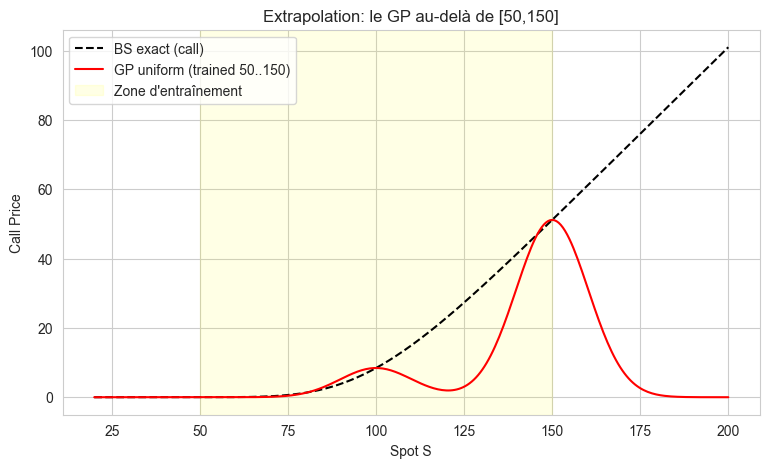

Observation : hors de [50,150], le GP peut être moins fiable.
Surtout si le kernel n'a pas été configuré pour extrapoler (linéaire ou autre).


In [ ]:
# ===========================
# 6) Tester les limites du modèle
# ===========================
#  => on va "extrapoler" en dehors de [50,150]
#     Ex: S in [20, 200] ?

S_extrap = np.linspace(20, 200, 300)
X_extrap = S_extrap.reshape(-1,1)

y_extrap_call_exact = [bs_call_price(s) for s in S_extrap]
y_extrap_call_pred  = gp_u.predict(X_extrap)  # on réutilise le GP uniform call

plt.figure()
plt.plot(S_extrap, y_extrap_call_exact, 'k--', label="BS exact (call)")
plt.plot(S_extrap, y_extrap_call_pred, 'r-', label="GP uniform (trained 50..150)")

plt.axvspan(50,150, color='yellow', alpha=0.1, label="Zone d'entraînement")
plt.title("Extrapolation: le GP au-delà de [50,150]")
plt.xlabel("Spot S")
plt.ylabel("Call Price")
plt.legend()
plt.show()

print("Observation : hors de [50,150], le GP peut être moins fiable.")
print("Surtout si le kernel n'a pas été configuré pour extrapoler (linéaire ou autre).")
